In [17]:
import pandas as pd
import re
import networkx as nx
from matplotlib import pyplot as plt
import more_itertools as mit
from collections import Counter
import typing as tp

In [18]:
def prep_goals(list_goals, type_graph=1):
    """Preprocesses DuRecDial goals for visualisation by leaving the first two words or renaming the goal.\n",

    Used for preprocessing goals from DuRecDial annotation datasets. 
    Simplified for now, more preprocessing tbd later.

    Args:
        list_goals: List of DuRecDial annotated dialogs.

    Returns:
        List of preprocessed DuRecDial annotated dialogs.
    """

    list_prerpocessed = []
    for n, goal in enumerate(list_goals):
        goal_text = goal.split('_')[0]
        text_spl = goal_text.split()
        if goal.split('_')[0] == 'nan':
            continue
        if len(text_spl) > 1:
            goal = ' '.join(text_spl[:2])
        if 'Q&' in goal_text:
            goal =  'Q&A about'
        if 'recommendation' in goal_text:
            goal =  'recommendation'
        if type_graph == 1:
            goal = goal.split('_')[0]+ '_' + str(n)
        elif type_graph == 2:
            goal = goal.split('_')[0]
        list_prerpocessed.append(goal)
    return list_prerpocessed


def get_nodes(dict_goal: dict[str, dict[tuple, int]]) -> dict[str, str]:
    """Get dictionary of nodes for then iteratively adding to graph.

    Get dictionary of nodes with position in dialog (1 for greeting_1, 2 for greeting_2, etc.) as key to later determine node positions.
    
    Args:
        dict_goal: Dictionary of goals with dialog beginning node as keys and nested dicts with all edges in these graphs as values.

    Returns: 
        Dictionary of node positions as keys and node names (with these positions) as values.
    """

    list_nodes = [item for sublist in dict_goal.keys() for item in sublist]
    nodes_positions = {}
    for node in list_nodes:
        position = node.split('_')[1]
        if position not in nodes_positions:
            nodes_positions[position] = [node]
        else:
            if node not in nodes_positions[position]:
                nodes_positions[position].append(node)
    return nodes_positions


def calculate_node_weights(G: nx.Graph) -> dict[str, int]:
    """Get node weight for each node in graph.

    Weight calcuated as sum of all incoming edge weights.

    Args:
        G: Networkx graph.

    Returns:
        Dictionary of weights for each node.
    """
    
    node_weights = {}
    for (_, node2, data) in G.edges(data=True):
        if node2 not in node_weights:
            node_weights[node2] = data['weight']
        else:
            node_weights[node2] += data['weight']
    return node_weights


def give_path_ids(dialog: list[str], path_ids: dict[tuple, int]) -> list[str]:
    """Rename each node according to its position in the graph.

    Ensure that each node is unique, i.e. nodes with same names but different ways to them are two different nodes. 
    Done in order to build an intersection-free version of the graph.

    Args:
        dialog: Dialog represented as an ordered list of goals/speech acts/etc.
        path_ids: Dictionary of unique ids for each path.

    Returns:
        List of uniquely named nodes.
    """
    
    output = [dialog[0]]
    for i in range(1, len(dialog)):
        path = tuple(dialog[: i])
        if path not in path_ids:
            path_ids[path] = len(path_ids)
        output.append(str(path_ids[path]) + ' | ' + dialog[i])
    return output


def make_dialog_dict(lists_goals: list[list[str]], list_first_goals: list[str], small_nodes: bool = False, use_ids: bool = False) -> dict[str, dict[tuple, int]]:
    """Create a dialog dictionary with separate entries for each possible beginning of the dialog.

    Args:
        lists_goals: Dialog represented as an ordered list of goals/speech acts/etc.
        list_first_goals: A dictionary of unique ids for each path.
        small_nodes: If True, edges and nodes with weight < 5 will be shown
        use_ids: If True, the graph will have a tree structure, with unique next nodes for each node (-> zero intersections)

    Returns:
        Dictionary with possible dialog beginnings as keys and dialog dictionaries.
        Structure of each dialog dictionary is edges (node1, node2) as keys and their weights as values.
    """

    dialog_dict = {}
    path_ids = {}
    for goal in list_first_goals:
        goal_chunks = []
        for dialog in lists_goals:
            if dialog[0] == goal:
                if use_ids:
                    proceed_dialog = give_path_ids(dialog, path_ids)
                else:
                    proceed_dialog = dialog
                chunks = [x for x in list(mit.windowed(proceed_dialog, n=2, step=1, fillvalue='end_1'))]
                goal_chunks += chunks
        dialog_dict[goal] = dict(Counter(goal_chunks))
        if not small_nodes:
            dialog_dict[goal] = {k: v for k, v in dialog_dict[goal].items() if v >= 5}
    return dialog_dict


def draw_graph(one_start: dict[str, dict[tuple, int]], size: tuple = (18,12)) -> None:
        """Draw a graph of a given size based on a given dialog dictionary.
        
        Args:
        one_start: One dialog represented as an ordered list of goals/dialog acts/etc.
        size: The size of the graph image.
        """

        if one_start:
                if len(one_start.keys()) > 1:
                        plt.figure(figsize=size)
                        G=nx.DiGraph()
                        nodes_dict = get_nodes(one_start)
                        for key, value in nodes_dict.items():
                                y_coord = 0
                                for node in sorted(value):
                                        G.add_node(node, pos=(int(key),y_coord))
                                        y_coord += 1
                        for key, value in one_start.items():
                                G.add_edge(key[0], key[1], weight=value)
                        widths = nx.get_edge_attributes(G, 'weight')
                        node_weights = calculate_node_weights(G)
                        max_weight = max(node_weights.values())
                        min_node_size = 100
                        max_node_size = 1000
                        for node in G.nodes():
                                G.nodes[node]['size'] = max_node_size
                        for node, weight in node_weights.items():
                                node_size = min_node_size + (max_node_size - min_node_size) * (weight / max_weight)
                                G.nodes[node]['size'] = node_size
                        nodelist = G.nodes()
                        dict_labels = dict(zip(nodelist,[x.split('|')[1].strip() if '|' in x else x for x in nodelist]))
                        pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=LR')
                        nx.draw_networkx_nodes(G,pos,
                                        nodelist=nodelist,
                                        node_size=[G.nodes[node]['size'] for node in nodelist],
                                        node_color='lightblue',
                                        alpha=0.7)
                        nx.draw_networkx_edges(G,pos,
                                        edgelist = widths.keys(),
                                        width=[x if x < 5 else 5 for x in list(widths.values())],
                                        edge_color='lightblue',
                                        alpha=0.6,
                                        arrowstyle='->,head_width=0.2,head_length=2')
                        nx.draw_networkx_labels(G, pos=pos,
                                                labels=dict_labels,
                                                font_color='black',
                                                font_size=8)
                        nx.draw_networkx_edge_labels(G,pos, 
                                                edge_labels ={(n1,n2): widths[n1,n2] for (n1,n2) in widths if widths[n1,n2] >=5},
                                                font_color='black',
                                                font_size=7)
                        plt.box(False)
                        plt.show()

In [19]:
def graph_from_file(anno_type: str, size: tp.Tuple[int, int] = (18,12), full: bool = False, unique: bool = False, out_of_set=False, example: str = '') -> None:
    """Draw a graph based on the file with dialogs.
        
    Args:
        filepath: Path to file with dialogs.
        full: If True, draw the entire graph. If False, omit edges and nodes with weight < 5.
        unique: If True, draw a tree-structure graph with no intersections and unique next nodes for each node.
        out_of_set: If True, draw all nodes, including erroneously generated out-of-goals-set.
        example: The name of the example graph to draw. Must be the name of its first node, e.g. 'greeting_0'
    """

    set_durec_goals = ['greeting', 'Q&A', 'chitchat', 'ask', 'recommendation', 'weather', 'goodbye']
    set_open_goals = ['wants', 'explains', 'expresses', 'gives', 'confirms', 'provides', 'agrees', 'informs', 'asks', 'mentions',
                      'offers', 'states', 'shares', 'suggests', 'shows', 'acknowledges', 'asking', 'requests', 'clarifies']
    if anno_type == 'durec_goals':
        filepath = 'dialog_data/processed/durec_fin.tsv'
    elif anno_type == 'open_goals':
        filepath = 'dialog_data/processed/open_fin.tsv'
    else:
        raise TypeError("You specified a non-existent anno_type. anno_type must be 'durec_goals' or 'open_goals'")
    data = pd.read_csv(filepath, sep='\t')
    d_as_goals = [x.split(': ')[1] for x in set(data['id_and_goal'])]
    number = re.compile(r'\[\d+\]')
    lists_goals = [re.split(number, x) for x in d_as_goals]
    lists_prep_goals = [prep_goals([x.strip() for x in y if x]) for y in lists_goals]
    list_first_goals = set(x[0] for x in lists_prep_goals)
    if anno_type == 'durec_goals':
        cut_lists = [[goal for goal in dialog if int(goal.split('_')[1]) < 6] for dialog in lists_prep_goals]
        if not out_of_set:
            cut_lists = [[goal if any(item in goal for item in set_durec_goals) else 'rare goal_' + goal.split('_')[1] for goal in dialog] for dialog in cut_lists]
    elif anno_type == 'open_goals':
        cut_lists = [[goal for goal in dialog if int(goal.split('_')[1]) < 10] for dialog in lists_prep_goals]
        if not out_of_set:
            cut_lists = [[goal if any(item in goal for item in set_open_goals) else 'rare goal_' + goal.split('_')[1] for goal in dialog] for dialog in cut_lists]
    dialog_dict = make_dialog_dict(cut_lists, list_first_goals, small_nodes=full, use_ids=unique)
    if example:
        draw_graph(dialog_dict[example], size=size)
    else:
        for dialog in dialog_dict:
            draw_graph(dialog_dict[dialog], size=size)

# Dialog graphs 

Each layer corresponds to the number of the goal/dialog act/etc. in a dialog (e.g., `<node>_0` is the beginning of the dialog, `<node>_1` is the second set of utterances united by a common goal, `<node>_2` is the third set of utterances united by a common goal, etc.) 

To make the graphs easier to understand, we show a separate graph for each possible beginning (first goal/dialog act/etc.) of a dialog. By default, the example graph for `greeting_0` is printed. To see all the graphs, just remove the `example` argument.

## DuRecDial

We removed goals annotated by ChatGPT that weren't part of DuRecDial goal-annotated dataset.

The list of remaining goals is:
 - greeting
 - Q&A about
 - chitchat about
 - ask about
 - recommendation
 - weather
 - saying goodbye

We also remove all goals after the 5th one; otherwise, the graphs would be to messy to analyse because of some rare but long outliers.

### Most common goals (edge weight > 5) without out-of-set

In this version, we only show most common goals (nodes and edges with weight < 5, i.e. seen in the dialogs less than 5 times, are removed).

Graph with no intersections and unique nodes for each path:

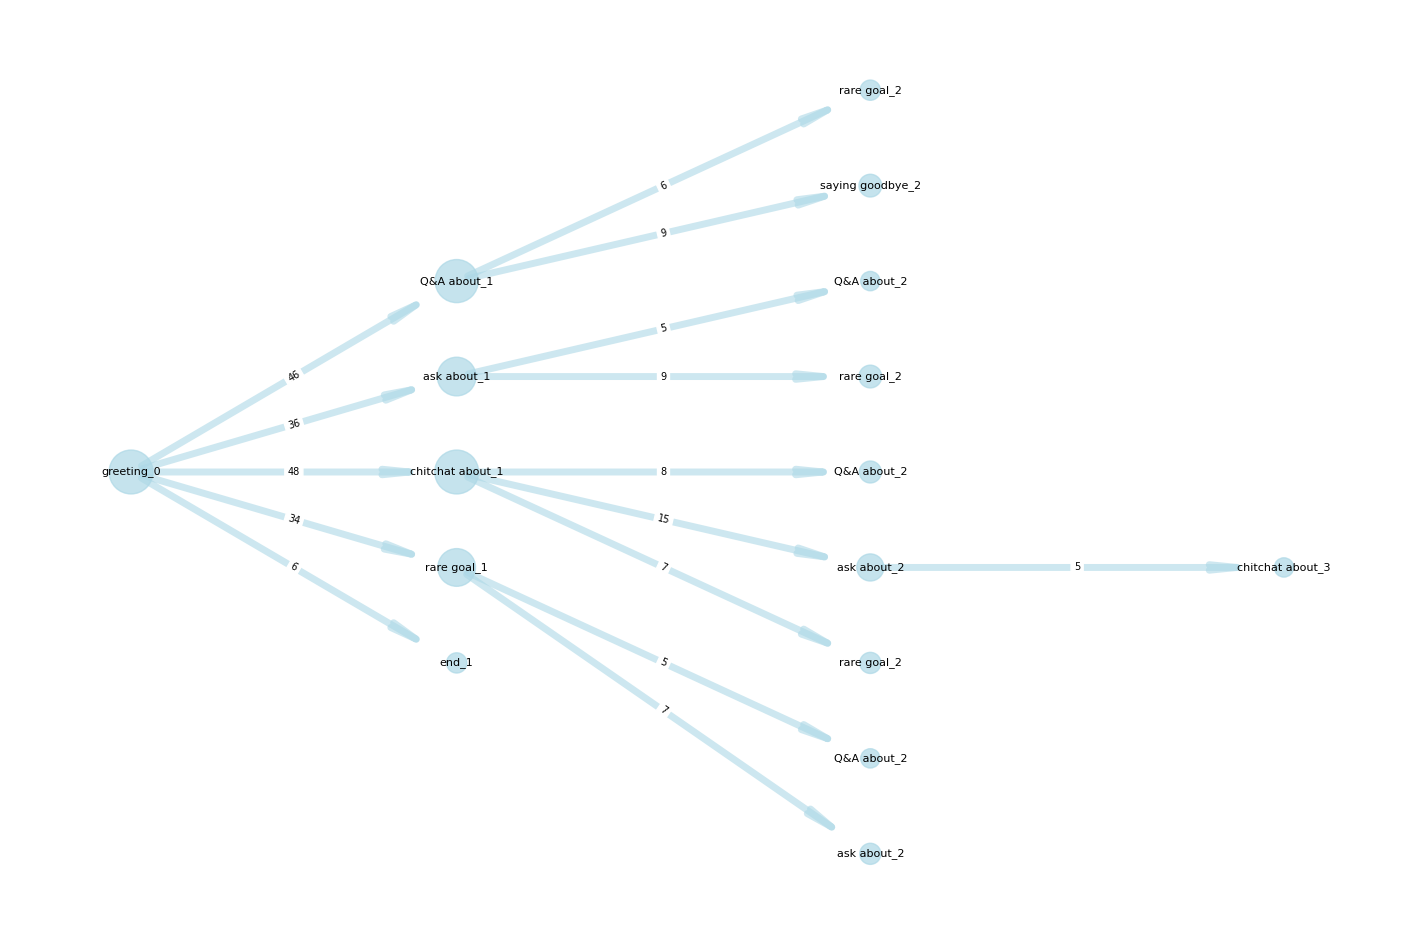

In [12]:
graph_from_file('durec_goals', full=False, unique=True, out_of_set=False, example='greeting_0')

Graph with intersections and the same nodes for each path:

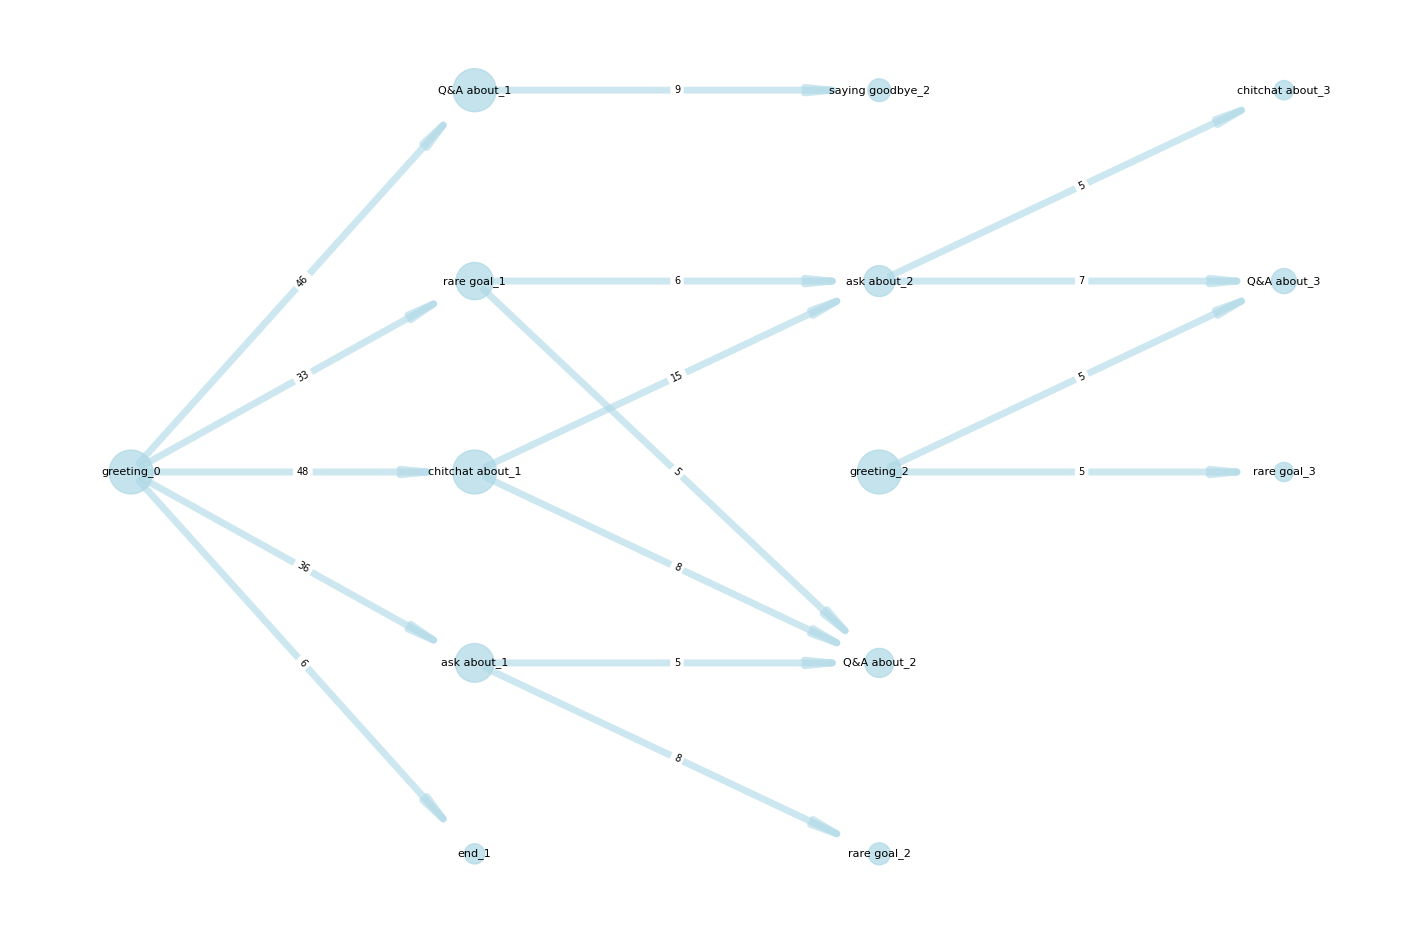

In [7]:
graph_from_file('durec_goals', full=False, unique=False, out_of_set=False, example='greeting_0')

### All goals without out-of-set

In this version, we show both common and rare goals.

Graph with no intersections and unique nodes for each path:

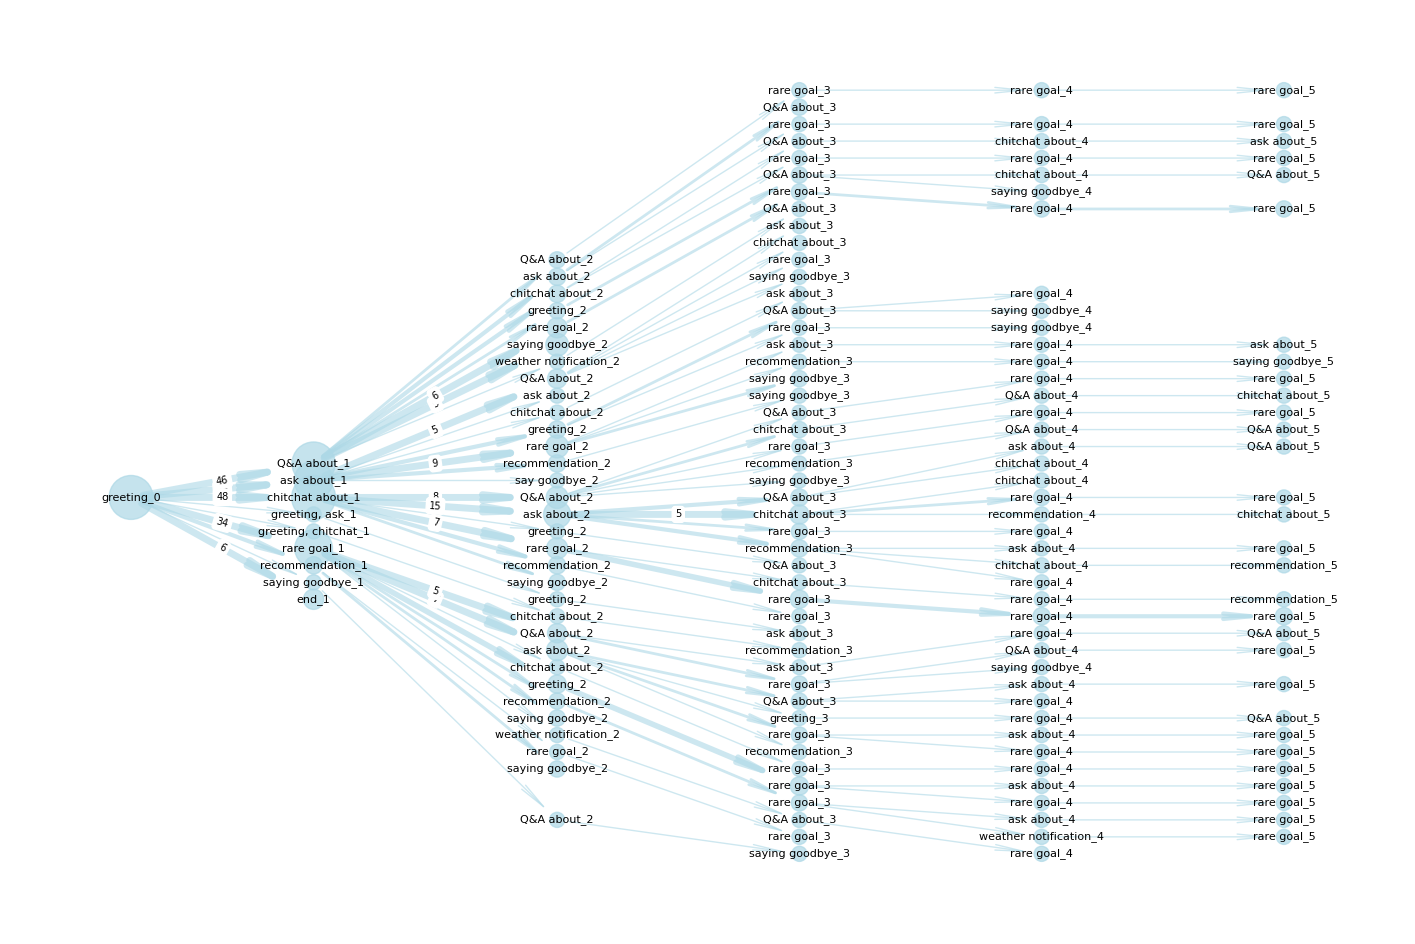

In [13]:
graph_from_file('durec_goals', full=True, unique=True, out_of_set=False, example='greeting_0')

Graph with intersections and the same nodes for each path:

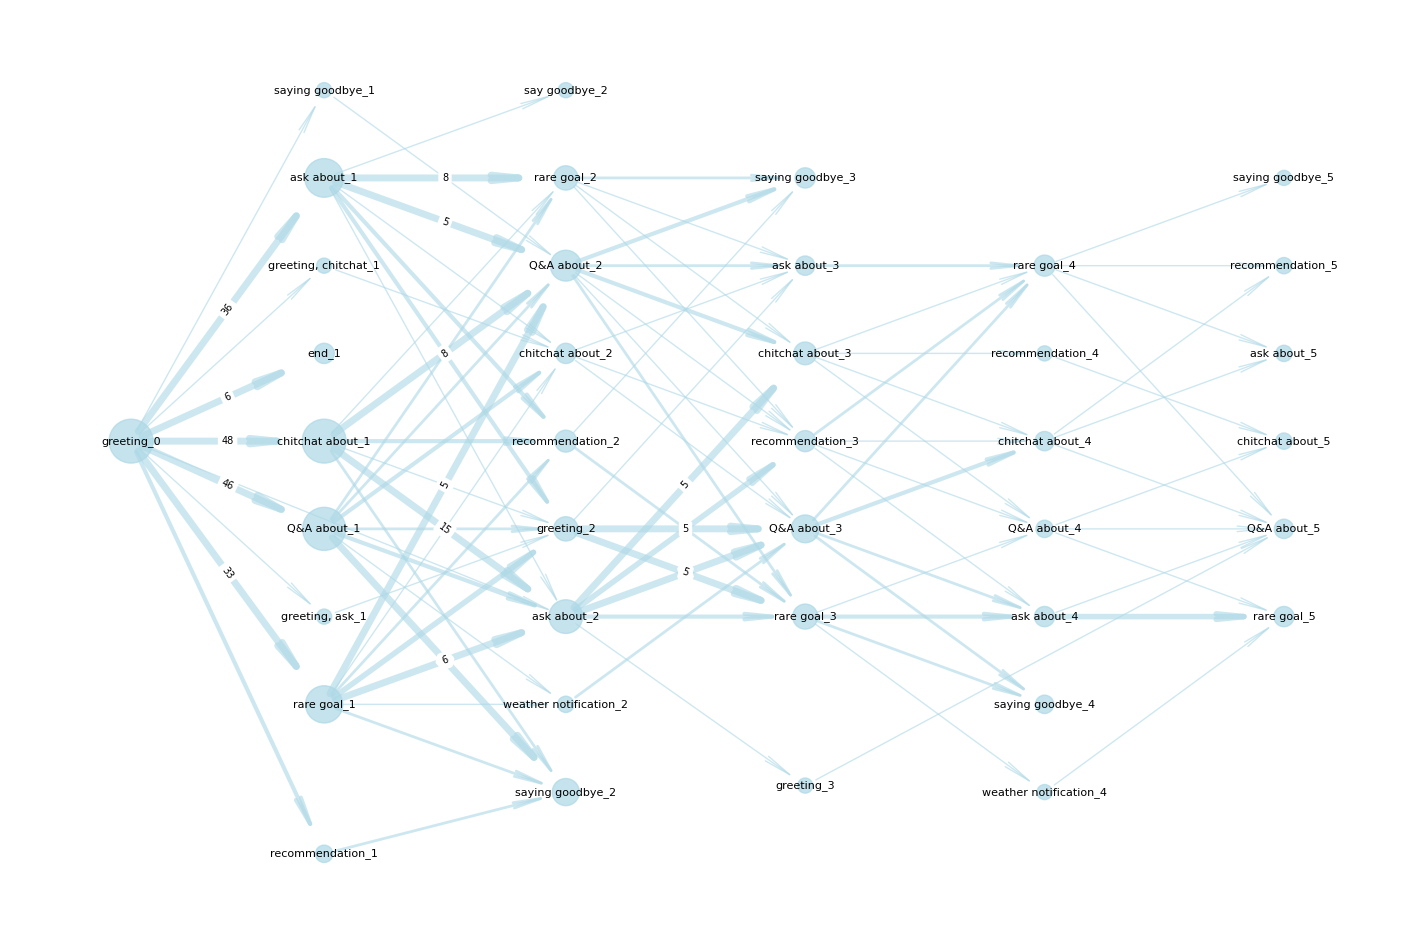

In [9]:
graph_from_file('durec_goals', full=True, unique=False, out_of_set=False, example='greeting_0')

## Open goals

Here, we annotated goals with ChatGPT without giving any specific instructions or sets of labels. To analyse the graph, we leave only 20 most common goals and group the other ones under label 'rare goal'.
We also remove all goals after the 10th one; otherwise, the graphs would be to messy to analyse because of some rare but long outliers.

### Most common (edge weight > 5)

In this version, we show both common and rare goals.

Graph with no intersections and unique nodes for each path:

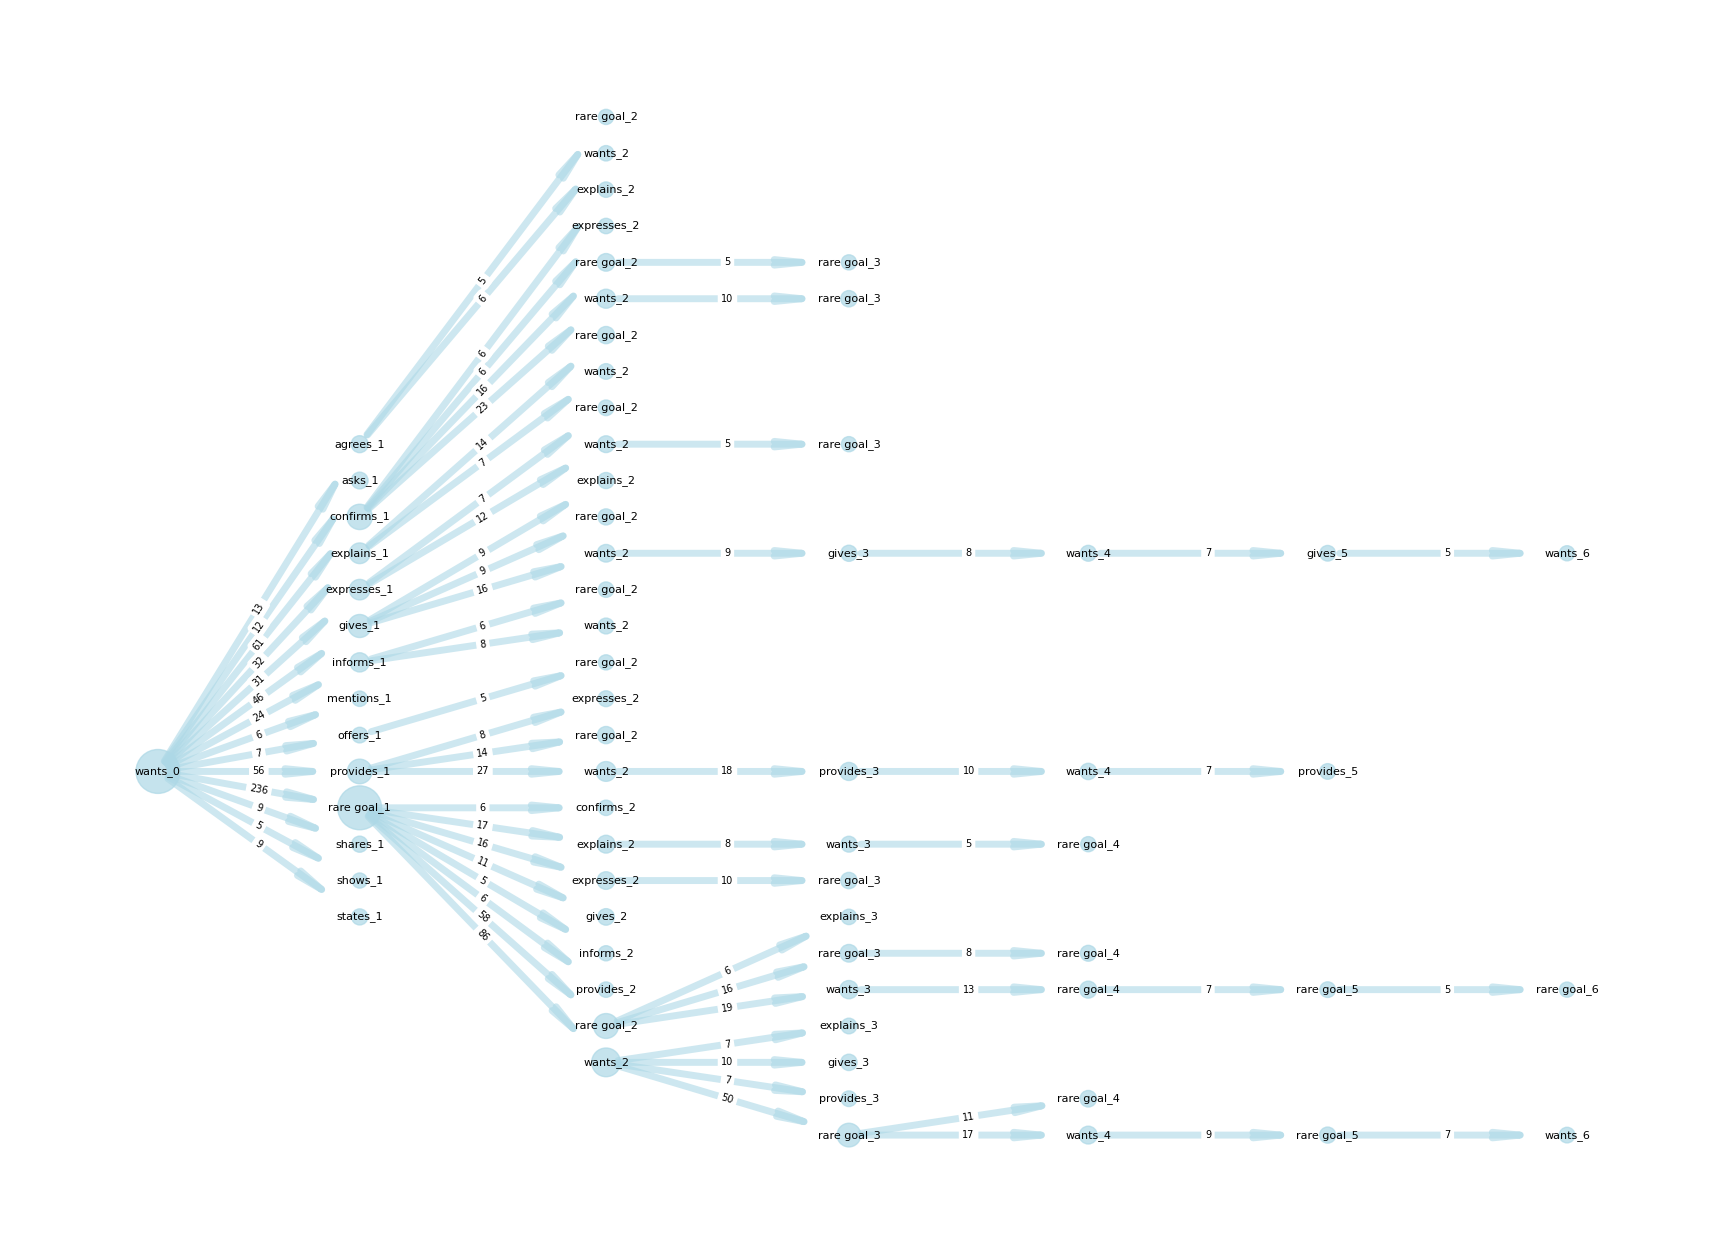

In [10]:
graph_from_file('open_goals', size=(22, 16), full=False, unique=True, out_of_set=False, example='wants_0')

Graph with intersections and the same nodes for each path:

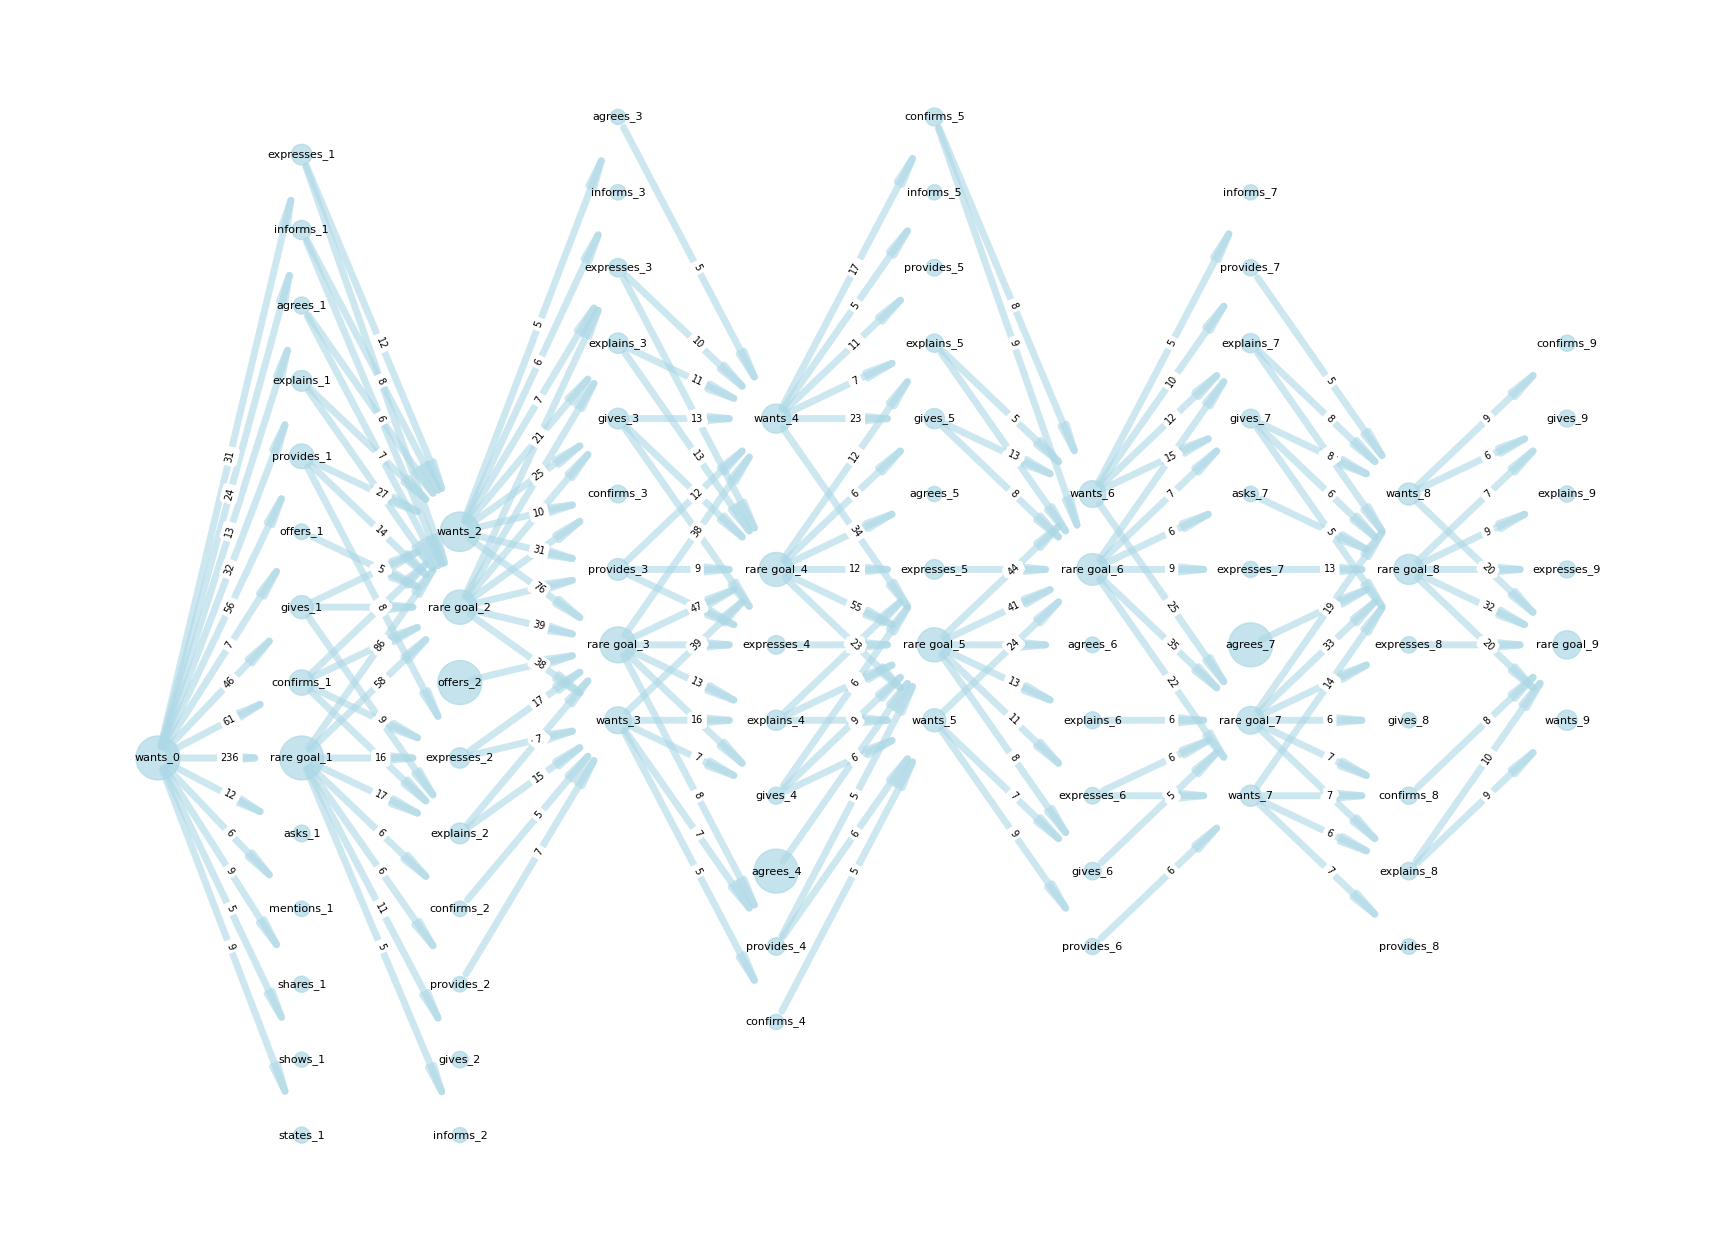

In [11]:
graph_from_file('open_goals', size=(22, 16), full=False, unique=False, out_of_set=False, example='wants_0')

### All

In this version, we show both common and rare goals. We do not show the graph with no intersections and unique nodes for each path as such graph would have been too massive.

Graph with intersections and the same nodes for each path:

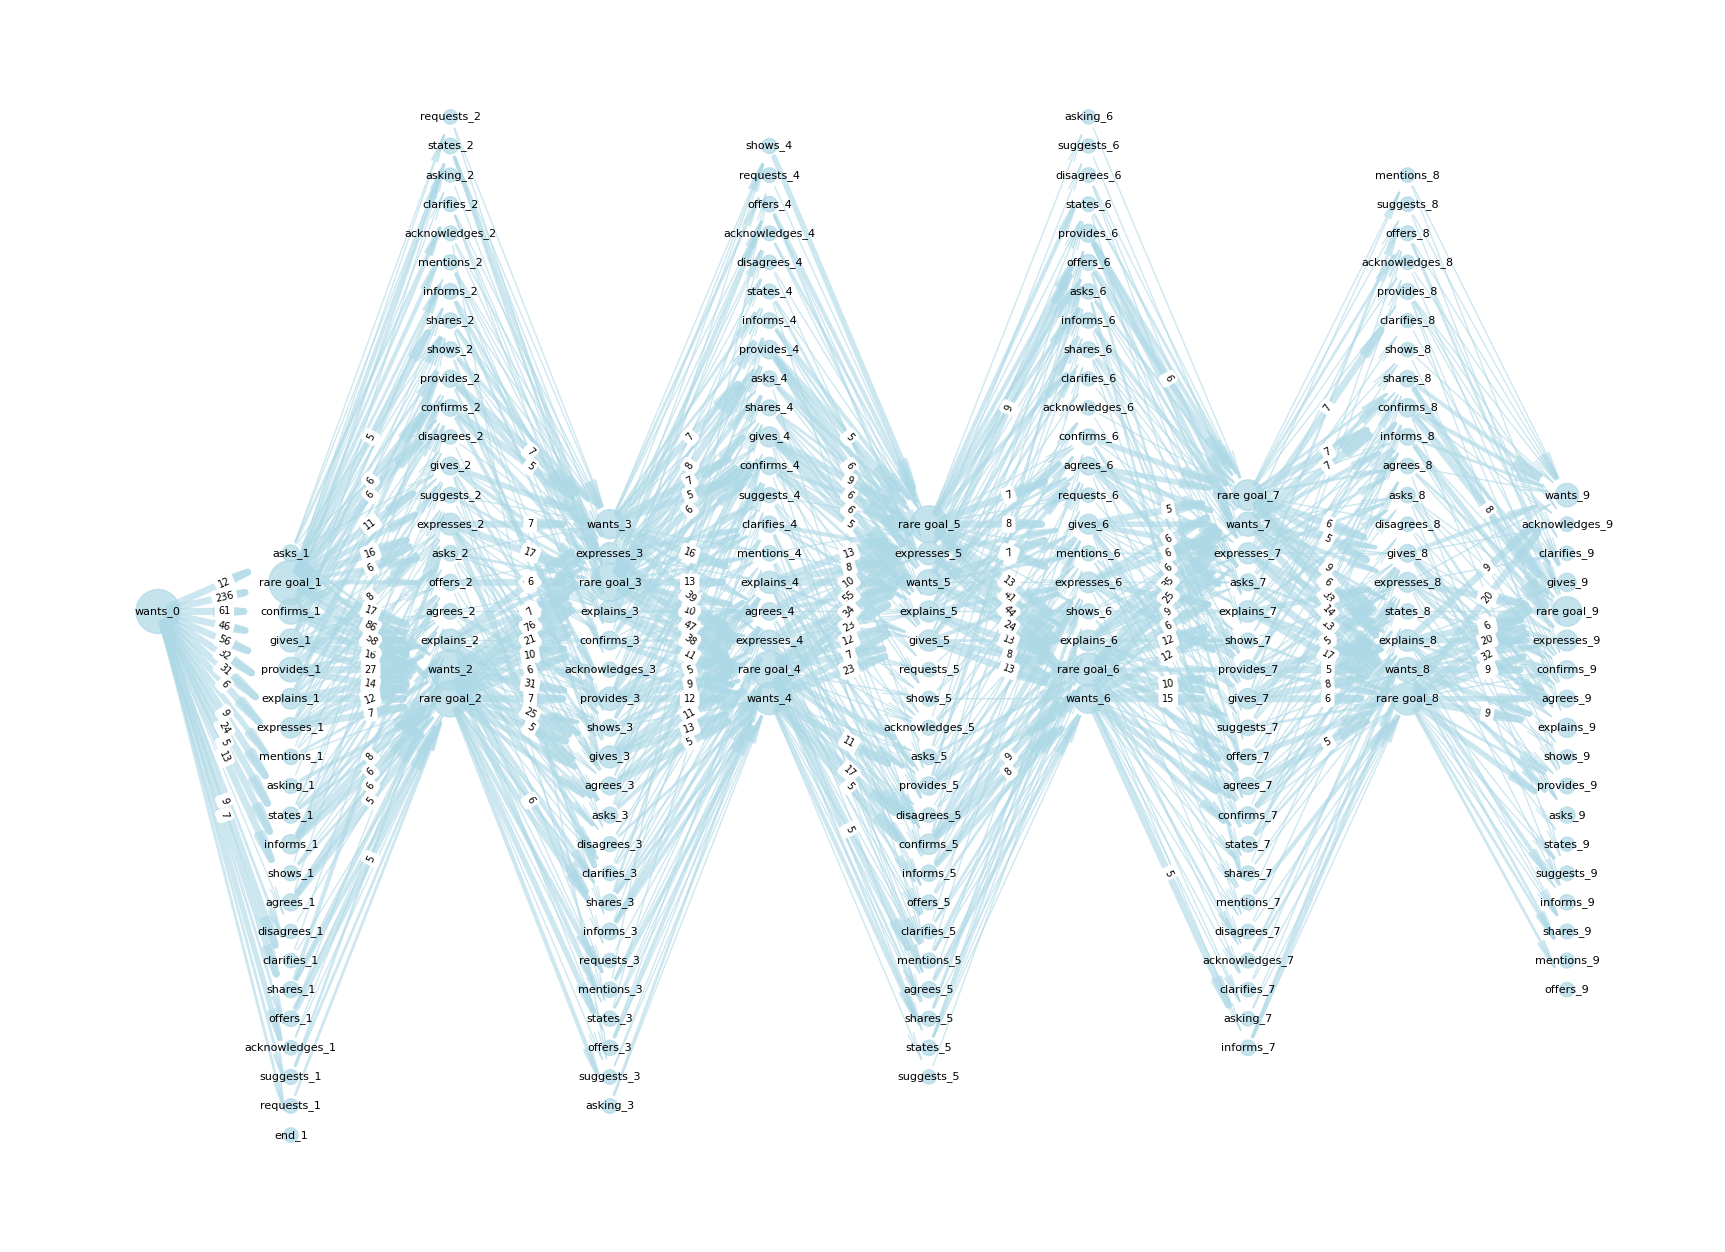

In [17]:
graph_from_file('open_goals', size=(22, 16), full=True, unique=False, out_of_set=False, example='wants_0')